# Redes Neurais Recorrentes

Long-Short Term Memory (LSTM) são um tipo de rede neural, mais especificamente um tipo de rede neural recorrente.

Redes neurais recorrentes possuem uma característica distinta de redes neurais feedforward. Ao invés da informação seguir um fluxo contínuo sempre em um direção (usualmente para "frente"), as RNNs passam a informação também de volta ("trás"). Isso permite que essas simulem uma memória, sendo capazes de lidar melhor com problemas que variam com o tempo, como é o nosso caso.

In [1]:
import torch
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

Vamos gerar alguns dados e visualizar como eles estão distribuídos usando o SkLearn, como vimos em aulas passadas!

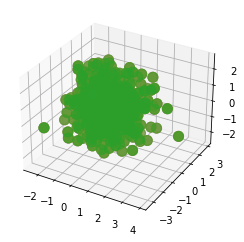

In [2]:
dummies = make_regression(n_samples=500, n_features=3)
feats, labels = dummies
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, mark, color in zip(range(3), ['o', '^', 'x'], ['red', 'blue', 'green']):
    cls_samples = feats[:, :]
    xoord = cls_samples[:, 0]
    yoord = cls_samples[:, 1]
    zoord = cls_samples[:, 2]
    scatter = ax.scatter(xoord, yoord, zoord, marker='o', s=100)

plt.show()
plt.close()

## Tensores

É a principal estrutura de dado do framework. Ela é essencialmente um array numpy de 3 dimensões. Entretanto, com tensores é possível realizar operações diretamente na GPU aumentando a eficiência dos algoritmos.

In [3]:
torch.rand(2, 3, 2)

tensor([[[0.4149, 0.5421],
         [0.0702, 0.6482],
         [0.1134, 0.3461]],

        [[0.6621, 0.0590],
         [0.4986, 0.7443],
         [0.5912, 0.7394]]])

Temos suporte direto a operações aritméticas assim como no numPy. Podemos realizar adições (`+`), subtrações (`-`), multiplicação por escalar (`*`), transposição (`T` ou `transp()`), produto de hadarmard (`*`), produto interno (`@`), entre outros.

In [4]:
A = torch.ones(2, 3, 2, dtype=torch.int) * 2
I = torch.eye(3, 2, dtype=torch.int)

In [5]:
A

tensor([[[2, 2],
         [2, 2],
         [2, 2]],

        [[2, 2],
         [2, 2],
         [2, 2]]], dtype=torch.int32)

In [6]:
I

tensor([[1, 0],
        [0, 1],
        [0, 0]], dtype=torch.int32)

In [7]:
A + I

tensor([[[3, 2],
         [2, 3],
         [2, 2]],

        [[3, 2],
         [2, 3],
         [2, 2]]], dtype=torch.int32)

In [8]:
A * I

tensor([[[2, 0],
         [0, 2],
         [0, 0]],

        [[2, 0],
         [0, 2],
         [0, 0]]], dtype=torch.int32)

In [9]:
# A * I == A @ I

In [10]:
A @ torch.eye(2, dtype=torch.int)

tensor([[[2, 2],
         [2, 2],
         [2, 2]],

        [[2, 2],
         [2, 2],
         [2, 2]]], dtype=torch.int32)

In [11]:
np.pi * A

tensor([[[6.2832, 6.2832],
         [6.2832, 6.2832],
         [6.2832, 6.2832]],

        [[6.2832, 6.2832],
         [6.2832, 6.2832],
         [6.2832, 6.2832]]])

In [12]:
rng = torch.rand(1, 3, 2)
A + rng

tensor([[[2.0963, 2.0285],
         [2.5349, 2.3385],
         [2.2162, 2.4669]],

        [[2.0963, 2.0285],
         [2.5349, 2.3385],
         [2.2162, 2.4669]]])

In [13]:
A.view(-1, 4)

tensor([[2, 2, 2, 2],
        [2, 2, 2, 2],
        [2, 2, 2, 2]], dtype=torch.int32)

A execução na GPU não ocorre de forma automática. Primeiro, podemos verificar se o dispositivo é suportado pelo PyTorch.

In [14]:
torch.cuda.is_available()

/home/thalesaguiar/.pyenv/versions/3.8.2/envs/fakenews.env/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


False

Em caso positivo, podemos especificar quais tensores terão suas operações executadas na placa gráfica, definir a execução de tudo por padrão.

In [15]:
# gpu = torch.device("cuda")
# A.to(gpu)
# cuda_tensor = torch.tensor([3, 4, 5], device=gpu)

In [16]:
tensor_feats, tensor_labels = torch.from_numpy(feats), torch.from_numpy(labels)
torchdata = torch.utils.data.TensorDataset(tensor_feats, tensor_labels)
torchdata[:3]

(tensor([[-0.4986,  0.8642,  2.2364],
         [-0.6171, -1.0694,  0.2756],
         [-1.2168,  0.0592, -1.0483]], dtype=torch.float64),
 tensor([ 218.1760,   -6.2278, -121.9096], dtype=torch.float64))

Acima, nos transformamos a base blob criada para um formato usado pelos modelos do framework. Também poderíamos usar o método `from_numpy`. A diferença seria o último cria uma view do array original, enquanto que o outro cria uma cópia.

In [17]:
a_view = A.view(-1, 3)
a_view

tensor([[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]], dtype=torch.int32)

In [18]:
A[0, 0, 0] = 99999
a_view

tensor([[99999,     2,     2],
        [    2,     2,     2],
        [    2,     2,     2],
        [    2,     2,     2]], dtype=torch.int32)

In [19]:
a_view[0, 2] = 55
A

tensor([[[99999,     2],
         [   55,     2],
         [    2,     2]],

        [[    2,     2],
         [    2,     2],
         [    2,     2]]], dtype=torch.int32)

## Rede Neural

O PyTorch permite criar modelos neurais com bastante facilidade e praticidade. Tanto a criação de modelos customizáveis e a grande quantidade de modelos prontos disponíveis é bastante simples. Vamos gerar um conjunto de dados aleatórios para experimentar as funções do framework.

In [20]:
feats = torch.rand(500, 3) * 100
targets = torch.rand(1, 500) * 50

(feats[:, :3], targets[:, :3])

(tensor([[15.7252, 99.8590, 29.2916],
         [87.2273, 25.2737, 62.8802],
         [39.0288, 30.6893, 40.1878],
         ...,
         [61.7946,  8.3024, 56.8246],
         [89.8929, 37.2331, 51.3660],
         [24.3357, 41.9888, 81.9197]]),
 tensor([[17.8581,  9.4159, 24.6354]]))

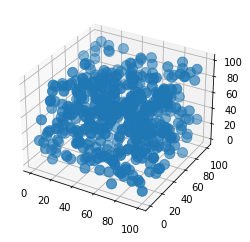

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(feats[:, 0], feats[:, 1], feats[:, 2], marker='o', s=100)
plt.show()

Por exemplo, abaixo podemos criar uma rede neural simples apenas usando os tensores.

In [22]:
weights = torch.rand(1, 3, requires_grad=True)
weights

tensor([[0.3719, 0.7314, 0.5054]], requires_grad=True)

In [23]:
bias = torch.rand(1, 1, requires_grad=True)
bias

tensor([[0.4217]], requires_grad=True)

O parâmetro `requires_grad` diz ao PyTorch que esse tensor deve ser levado em consideração quando algum otimizador for utilizado. Ou seja, no momento que fazemos a propagação do erro, esse tensor será atualizado.

Então, temos o seguinte problema:

$$y = D \times W + b$$

Onde $D$ é nossa base (apenas *features*), $W$ são os pesos, $b$ é um bias representando possíveis ruídos/erros obtidos das aproximações e $y$ são nossos valores esperados. Ou seja

$$\hat{y} = D \times W^{'} + b^{'}$$

Sendo $\hat{y}$ um valor próximo o suficiente de $y$, assim como $W^{'}$ e $b^{'}$.

In [24]:
yhat = feats @ weights.T + bias
yhat[:3]

tensor([[94.1122],
        [83.1280],
        [57.6944]], grad_fn=<SliceBackward>)

In [25]:
def model(feats):
    return feats @ weights.T + bias

Agora, precisamos definir a função objetivo. Vamos usar um simples Mean Squared Error.

In [26]:
sqr_diff = (targets - yhat) ** 2
torch.sum(sqr_diff) / sqr_diff.numel()

tensor(4076.6643, grad_fn=<DivBackward0>)

A operação `numel()` retorna a quantidade de elementos do tensor. Vamos criar uma função para calcular o erro

In [27]:
def mse(preds, real):
    diff = (real - preds) ** 2
    return torch.sum(diff) / diff.numel()

Para descobrir o quanto atualizar cada peso, vamos aplicar o *gradient descent*. 

In [28]:
loss = mse(targets, yhat)
loss.backward()
weights

tensor([[0.3719, 0.7314, 0.5054]], requires_grad=True)

Note que os valores do tensor não foram atualizados após executar o backpropagation. Isso é porque os valores do gradiente são armazenados no atributo `grad` de cada tensor

In [29]:
weights.grad

tensor([[6372.0532, 6672.2568, 6403.3765]])

Agora, podemos atualizar o tensor com o seu gradiente. Aqui devemos tomar cuidado, pois o PyTorch controla e memoriza todas as operações realizadas nos tensores com `require_grad=True` para utilizar no cálculo dos gradientes. Para atualizar os parâmetros, não queremos que essa operação seja gravada. Para evitar esse comortamento, podemos usar o operador de contexto `with` com a função `torch.no_grad()`.

In [30]:
# hyperparameters
weights.grad.zero_()
bias.grad.zero_()

nepochs = 250
lrate = 1e-5

for epoch in range(nepochs):
    predictions = model(feats)
    loss = mse(predictions, targets)
    loss.backward()
    if epoch % 10 == 0:
        print(f'{epoch:3}° {loss}')
    with torch.no_grad():
        weights -= weights.grad * lrate
        bias -= bias.grad * lrate
        weights.grad.zero_()
        bias.grad.zero_()

  0° 4076.664306640625
 10° 396.0240783691406
 20° 290.1140441894531
 30° 279.009033203125
 40° 272.73492431640625
 50° 268.3001708984375
 60° 265.1362609863281
 70° 262.87774658203125
 80° 261.26513671875
 90° 260.1133728027344
100° 259.2903747558594
110° 258.7021179199219
120° 258.2813720703125
130° 257.98016357421875
140° 257.76434326171875
150° 257.6094665527344
160° 257.49810791015625
170° 257.4178466796875
180° 257.3598327636719
190° 257.3176574707031
200° 257.2868347167969
210° 257.26409912109375
220° 257.2471618652344
230° 257.2343444824219
240° 257.2244873046875


In [31]:
pred = model(feats)
loss = mse(pred, targets)
loss

tensor(257.2168, grad_fn=<DivBackward0>)

In [49]:
targets - pred

tensor([[18.8159, 10.3737, 25.5931,  ..., 19.4019, 25.6622,  4.1732],
        [18.3271,  9.8849, 25.1044,  ..., 18.9131, 25.1735,  3.6844],
        [18.3212,  9.8790, 25.0984,  ..., 18.9072, 25.1675,  3.6785],
        ...,
        [17.6359,  9.1937, 24.4132,  ..., 18.2219, 24.4823,  2.9933],
        [17.3781,  8.9359, 24.1554,  ..., 17.9641, 24.2245,  2.7355],
        [18.5420, 10.0998, 25.3193,  ..., 19.1280, 25.3884,  3.8994]],
       grad_fn=<SubBackward0>)

Esse comportamento é devido a estratégia para automaticamente gerar o gradiente de qualquer estrutura. O PyTorch (e provavelmente outros) transforma o gradiente descendente/backpropagation em um grafo onde cada nó é uma operação. Assim, ele só precisa gerar a derivada de cada nó e aplicar o backpropagation.

### Otimizador

Também podemos selecionar qual tipo de otimizador usaremos para ajustar os parâmetros. O mais comum é o Stochastic Gradient Descent (SGD), mas o PyTorch oferece o Adadelta, Adagrad, RMSProp, entre vários outros dentro do pacoto `torch.optim`. Além disso, claro, também podemos customizar e criar o nosso próprio otimizador.

In [33]:
?torch.optim.RMSprop

Init signature:
torch.optim.RMSprop(
    params,
    lr=0.01,
    alpha=0.99,
    eps=1e-08,
    weight_decay=0,
    momentum=0,
    centered=False,
)
Docstring:     
Implements RMSprop algorithm.

Proposed by G. Hinton in his
`course <https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf>`_.

The centered version first appears in `Generating Sequences
With Recurrent Neural Networks <https://arxiv.org/pdf/1308.0850v5.pdf>`_.

The implementation here takes the square root of the gradient average before
adding epsilon (note that TensorFlow interchanges these two operations). The effective
learning rate is thus :math:`\alpha/(\sqrt{v} + \epsilon)` where :math:`\alpha`
is the scheduled learning rate and :math:`v` is the weighted moving average
of the squared gradient.

Arguments:
    params (iterable): iterable of parameters to optimize or dicts defining
        parameter groups
    lr (float, optional): learning rate (default: 1e-2)
    momentum (float, optional): momen

Em geral, os otimizadores são variações do Gradient Descent/Backpropagation. Mas alguns são melhores para evitar cair em mínimos locais, ou mesmo para quantidade de épocas necessárias. Outros, como o Adam, podem aumentar a complexidade da otimização ao utilizar valores diferentes para cada parâmetro, consequentemente aumentando também a flexibilidade.

In [34]:
network = torch.nn.Linear(3, 1)
print(network.weight)
print(network.bias)

Parameter containing:
tensor([[ 0.4079, -0.0461, -0.2285]], requires_grad=True)
Parameter containing:
tensor([-0.2035], requires_grad=True)


In [35]:
float_feats = tensor_feats.type(torch.float)
pred = network(float_feats)
pred[:3]

tensor([[-0.9577],
        [-0.4690],
        [-0.4630]], grad_fn=<SliceBackward>)

In [36]:
mse = torch.nn.functional.mse_loss
mse(pred.T, tensor_labels)

<ipython-input-36-48db3b8d8f68>:2: UserWarning: Using a target size (torch.Size([500])) that is different to the input size (torch.Size([1, 500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse(pred.T, tensor_labels)


tensor(9263.9841, dtype=torch.float64, grad_fn=<MseLossBackward>)

In [37]:
optim = torch.optim.SGD(network.parameters(), lr=1e-5)
adam = torch.optim.Adam(network.parameters(), lr=1e-5)

## Rede Recorrente

Para redes recorrentes também temos uma classe pronta para ser usada. 

In [38]:
# instancia rnn

O treinamento (backpropagation through time) é executado automaticamente com a seuinte instrução

In [39]:
# treina

Com o modelo treinado, podemos realizar nossos testes.

In [40]:
# testa

Usualmente, as classes do pacote `nn` são tratadas como layers. Ou seja, uma instância da RNN é um layer. Dessa forma, fica fácil gerar modelos complexos e altamente customizáveis. Por exemplo, podemos criar uma Rede Convolucional Recorrente entre outros franksteins.

In [41]:
# frankstein

### LSTM

Como vimos na parte teórica, a LSTM nada mais é que uma variação do "neurônio" de uma RNN.

![lstmhidden](imgs/lstmhidden.png)

O PyTorch também possui uma classe para o LSTM, tendo em vista sua popularidade.

In [42]:
# instancia LSTM

Na instância acima, definimos uma LSTM onde o *hidden state* possui dimensão $M\times N\times S$. Uma característica específica da LSTM nesse framework é a entrada esperada e o estado. Ambos devem ser tensores tridimensionais. Podemos treinar a rede ao propagar um elemento da sequência por vez

In [43]:
# treina 1 em 1

Enquanto que para usar todos os elementos precisamos concatenar nossos dados.

In [44]:
# todos de uma vez

Principalmente em NLP, a transformação do texto para representação numérica é bastante comum. Dessa forma, podemos criar uma LSTM customizada ao adicionar um layer de embedding que fica responsável por essa transformação.

In [45]:
# cria classe com embedding layer

Assim como podemos usar o novo layer durante o treinamento, aprendendo os embeddings de acordo com a task.

In [46]:
# treina embedding + lstm

Claro que também podemos criar vários franksteins, da mesma forma que fizemos com a RNN. Note que o *gradient descent* é totalmente genérico. Isto é, ele não depende da arquitetura do seu modelo, apenas que as funções de ativação sejam deriváveis ou deriváveis por partes. Por isso podemos criar estruturas totalmente **idiotas**, com valores indo, voltando, pulando, ignorando, com muito layer, e com o que quisermos.

In [47]:
# cria frankstein

É importante notar que redes profundas tendem a ocasionar *overfitting*, assim como os problemas decorrentes do algoritmo de aprendizado:

* Vanishing
* Exploding